# DM-25125: Monthly June 2020 ap_pipe HiTS2015 reprocessing

### The HiTS dataset and AP Pipeline
I ran ap_pipe.py via slurm on the HiTS2015 dataset. I used coadds built in Jan 2020 from HiTS2014 as templates. The dataset consists of 3 fields (pointings), each visited 28 times, all in _g_ band. Two of the fields have a small spatial overlap.

Running ap_pipe saves information about DIA Objects and DIA Sources in an Alert Production Database (APDB), which I use for the majority of this notebook. "Filtered" or "Good" means DIA Sources with one or more of the "bad," "saturated center," or "suspect" pixel flags have been excluded.

I ran this June 2020 rerun using the weekly build `w_2020_24`.

### Little change from May 2020, though I had expected source counts to return to April 2020 levels
The results from the June 2020 rerun are virtually identical to the May 2020 rerun, which used `w_2020_20`. However, the earlier April 2020 rerun (circa `w_2020_15`) had notably fewer DIA Sources. I thought the increase from April to May was most likely due to an ISR bug (fixed in DM-25149), but now I think it was due to a change in image differencing, because the calexp source counts have not changed. The new sources are prominently concentrated near CCD edges, which is a bit odd - did pixel masking change while the overall number of DIA Sources remained unchanged, perhaps? - but despite many new sources near edges, some do also appear all across CCDs.

The most substantial difference imaging change in the relevant timeframe was the decorrelation algorithm (DM-24371). In the ap_verify CI metrics, we noted a decrease in the total number of unassociated DIA Objects as well as changes in the ratio of DIA Sources to direct image sources for each CCD. However, the templates used by ap_verify CI changed to higher resolution at the same time, so it is difficult to determine cause and effect.

I suggest investigating the significant (~8%) increase in DIA Sources which happened somewhere during difference imaging and are likely attributable to DM-24371.

In [22]:
%matplotlib notebook

import sys
import numpy as np
import matplotlib.pyplot as plt
import importlib
import pandas as pd

from astropy.coordinates import SkyCoord
import astropy.units as u

import lsst.daf.persistence as dafPersist

In [3]:
sys.path.append('/project/mrawls/ap_pipe-notebooks/')
import diaObjectAnalysis as doa
import apdbPlots as pla

In [ ]:
# Only if you change anything in the code imported above
importlib.reload(doa)
importlib.reload(pla)

In [4]:
repo = '/project/mrawls/hits2015/rerun/cw_2020_06'

In [5]:
objTable, srcTable, goodObj, goodSrc = pla.loadTables(repo)

<IPython.core.display.Javascript object>


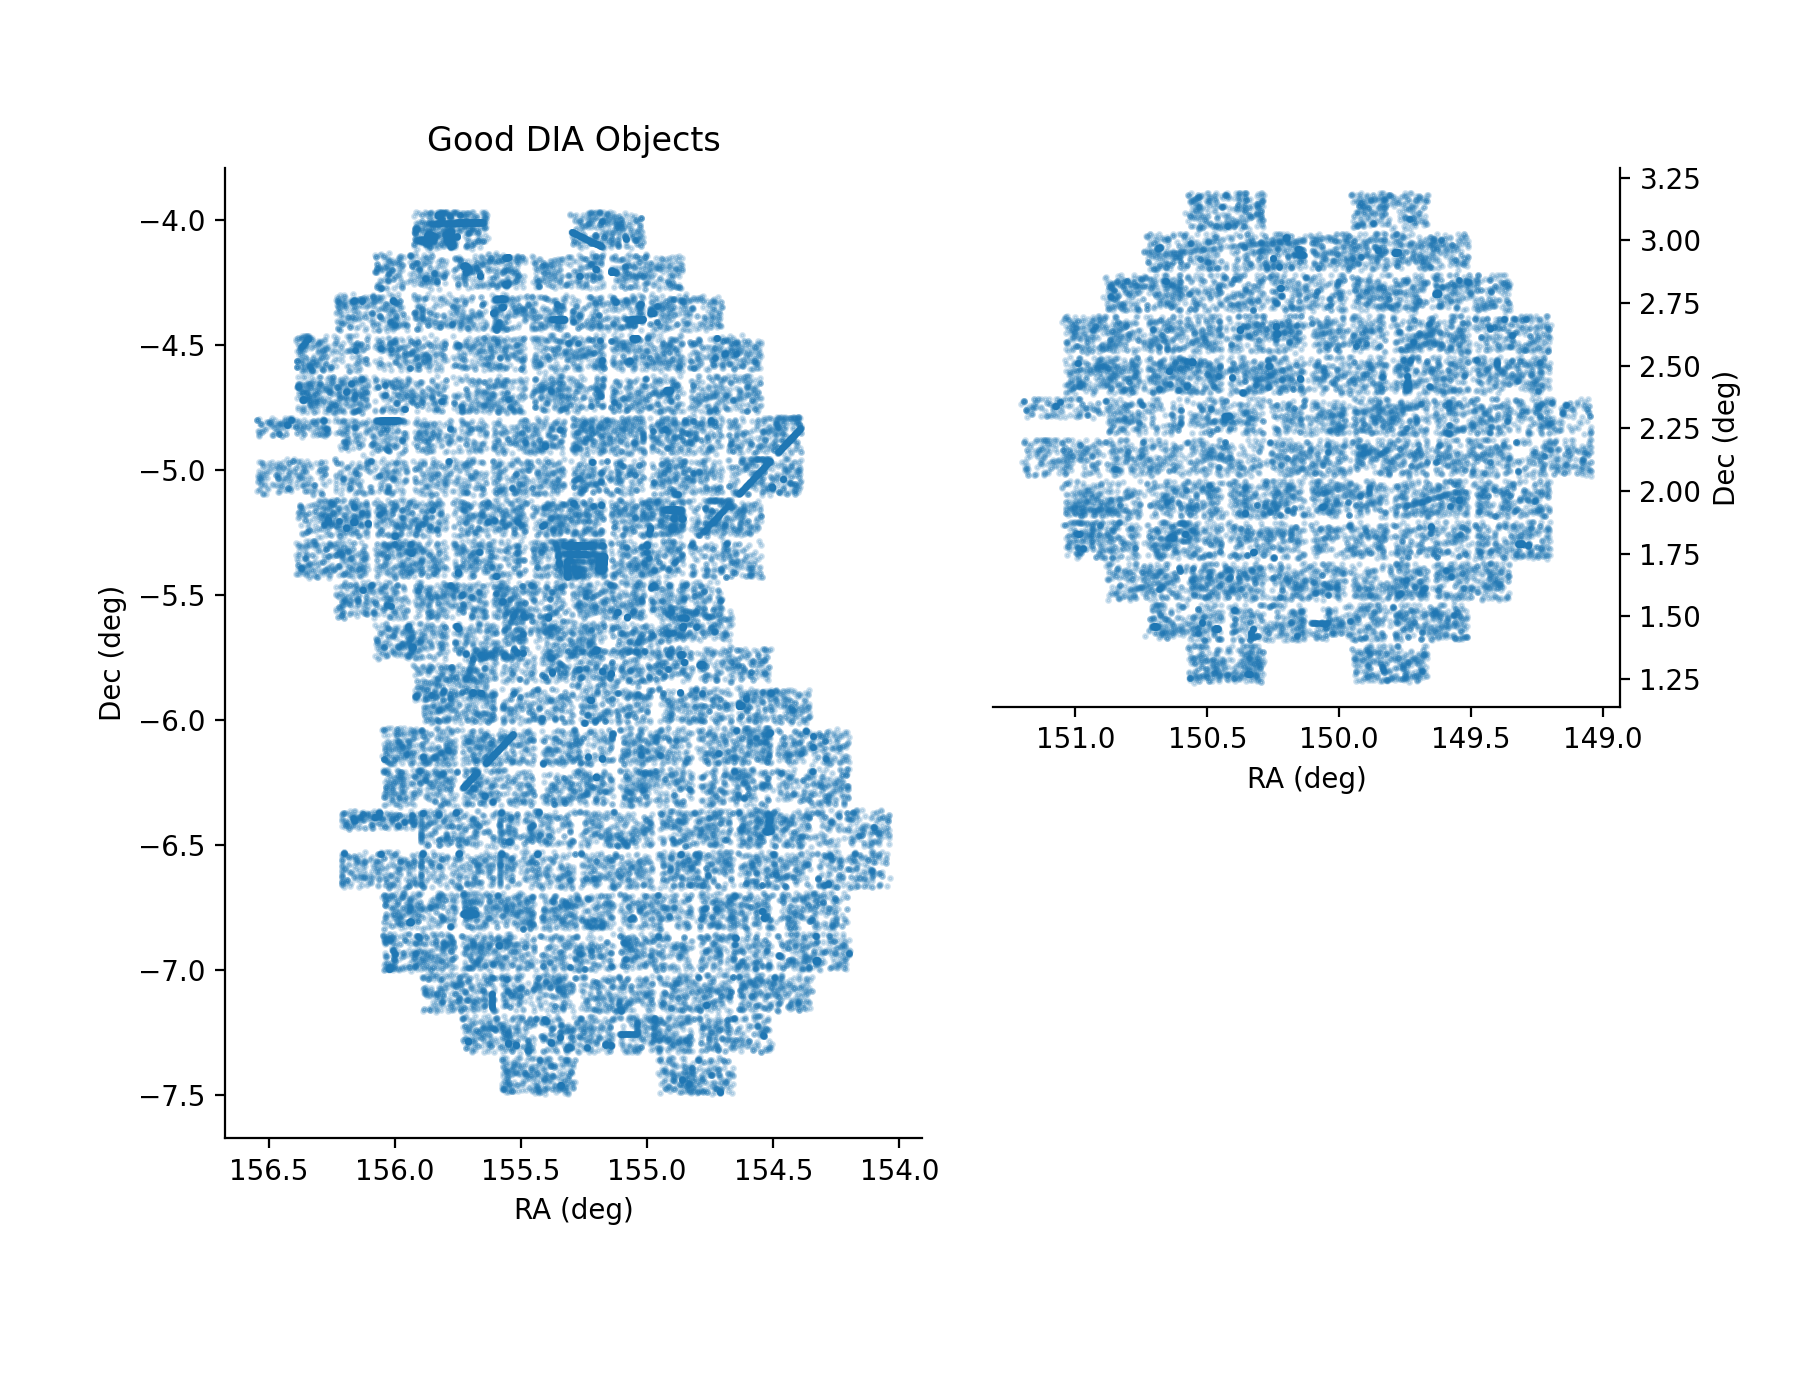

In [6]:
hitsPlot = pla.plotHitsSourcesOnSky(goodObj, title='Good DIA Objects')

<IPython.core.display.Javascript object>


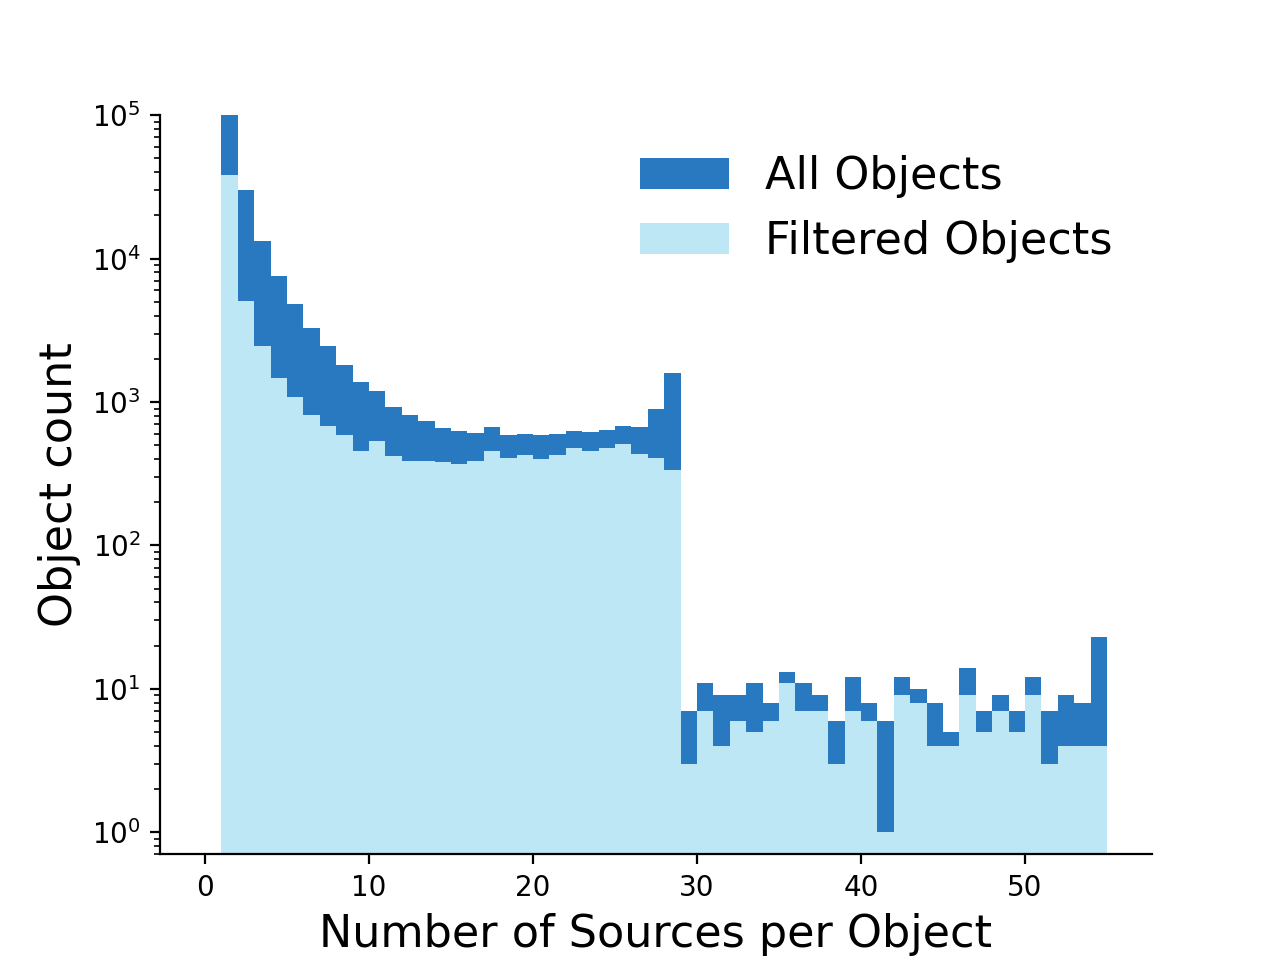

In [7]:
hist = doa.plotDiaObjectHistogram(objTable, goodObj)

<IPython.core.display.Javascript object>


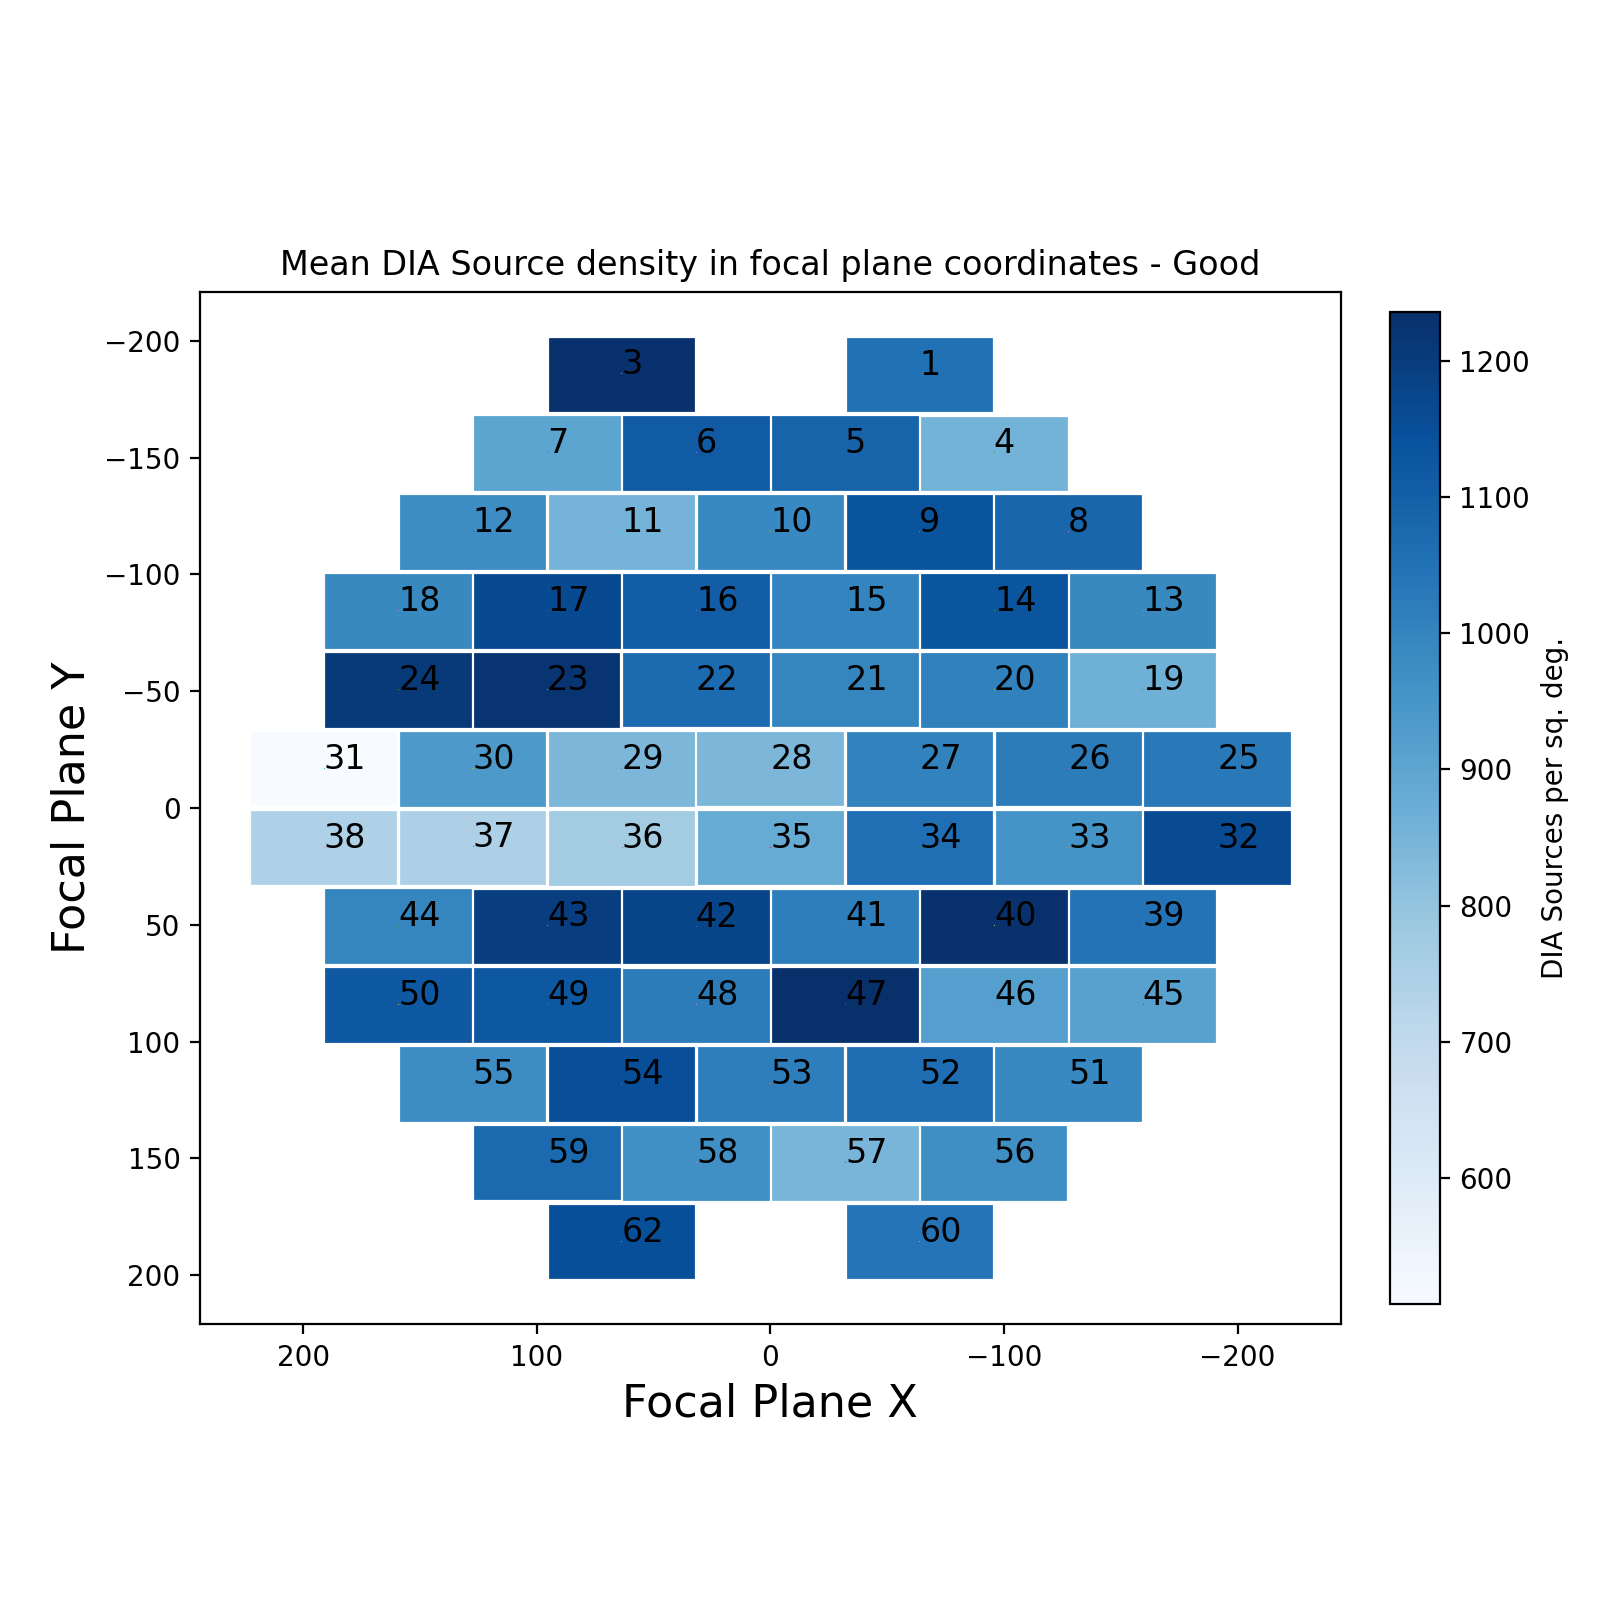

In [8]:
pla.plotDiaSourceDensityInFocalPlane(repo, goodSrc, title='- Good')

<IPython.core.display.Javascript object>


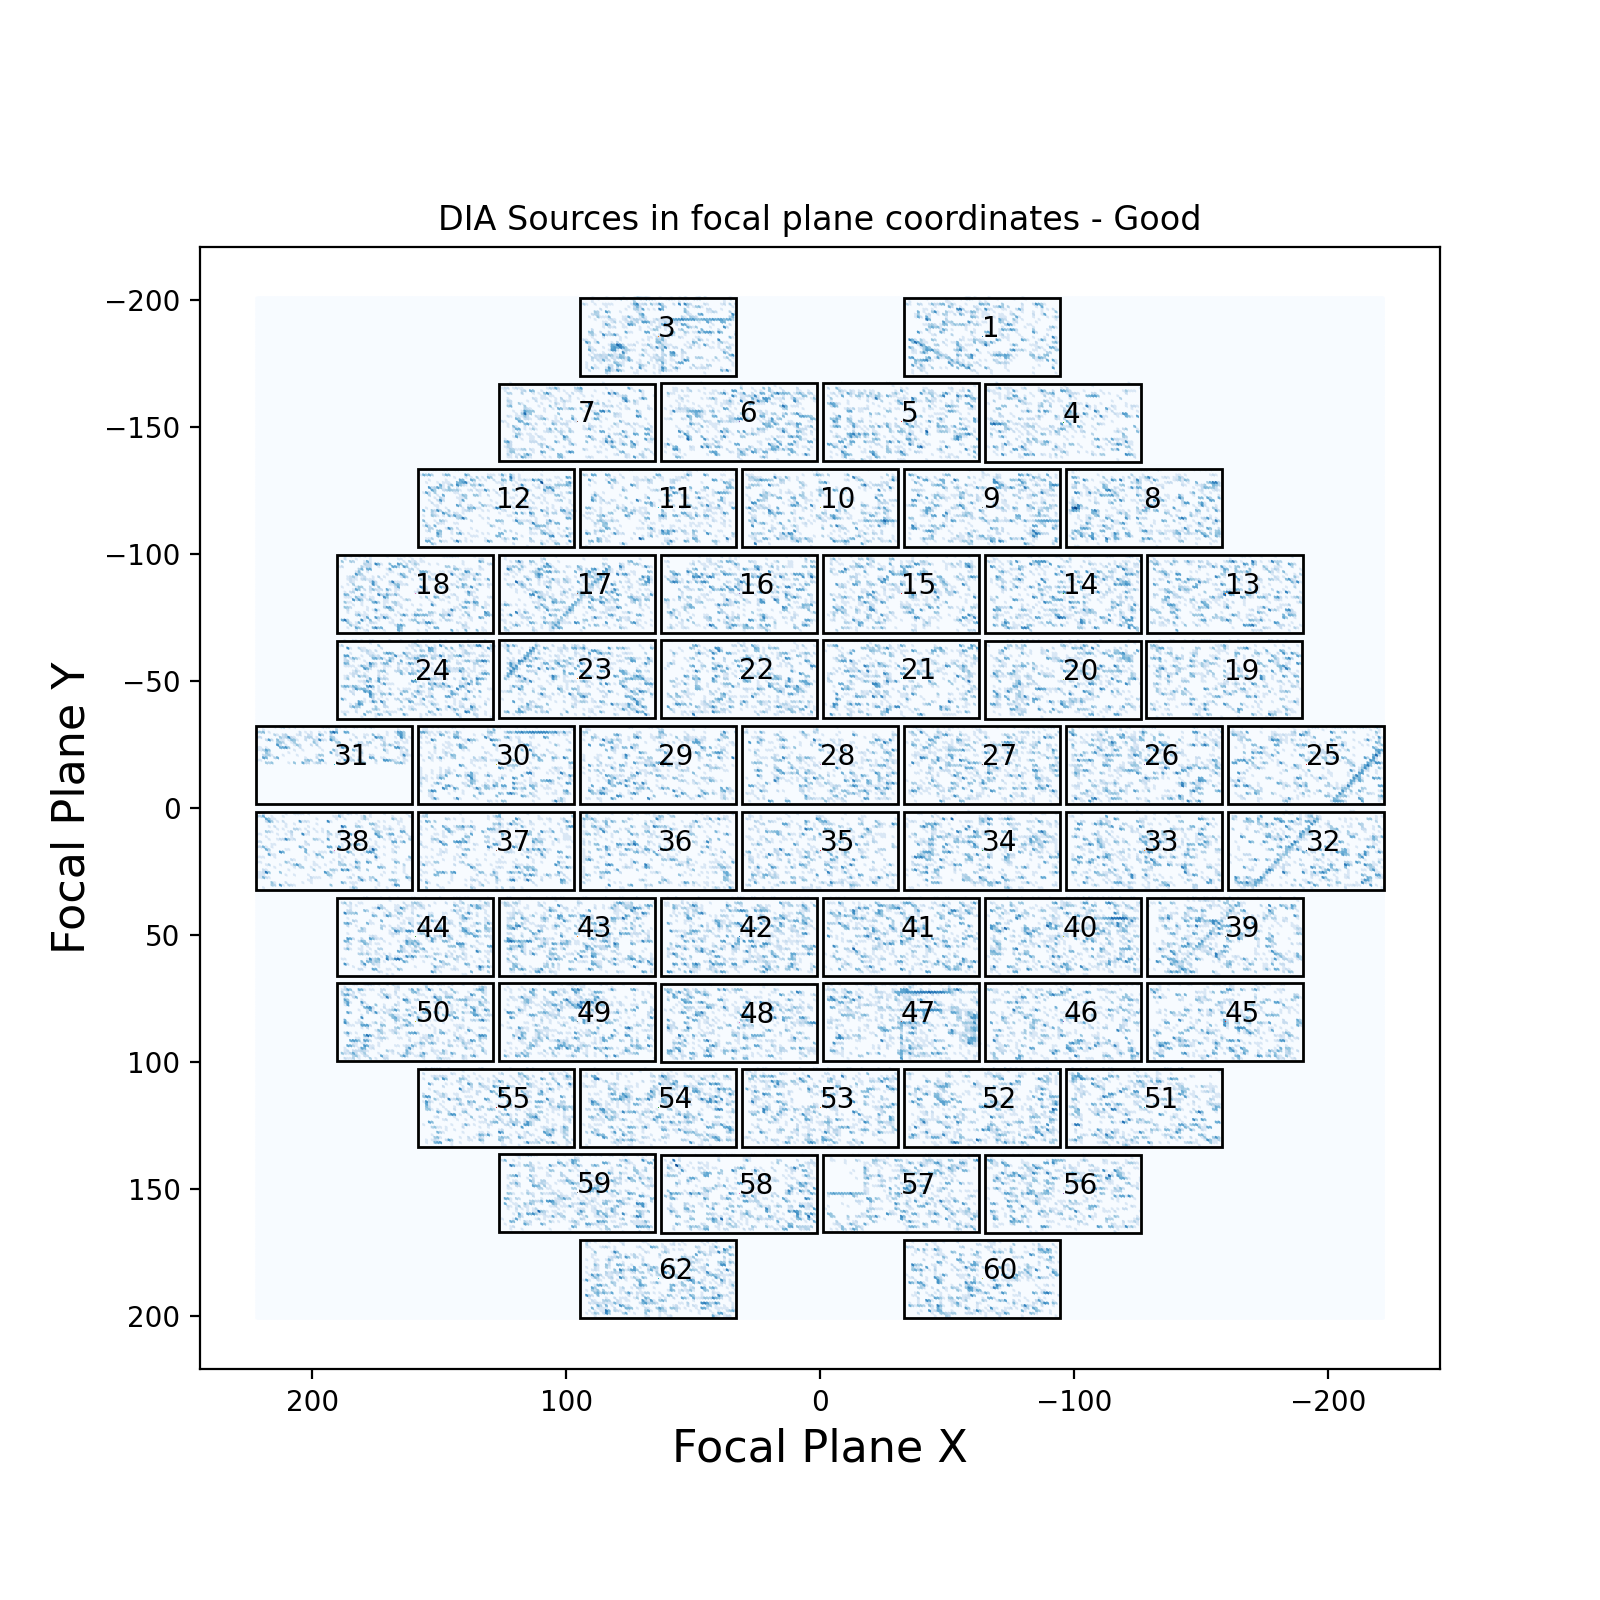

In [9]:
pla.plotDiaSourcesInFocalPlane(repo, goodSrc, title='- Good')

<IPython.core.display.Javascript object>


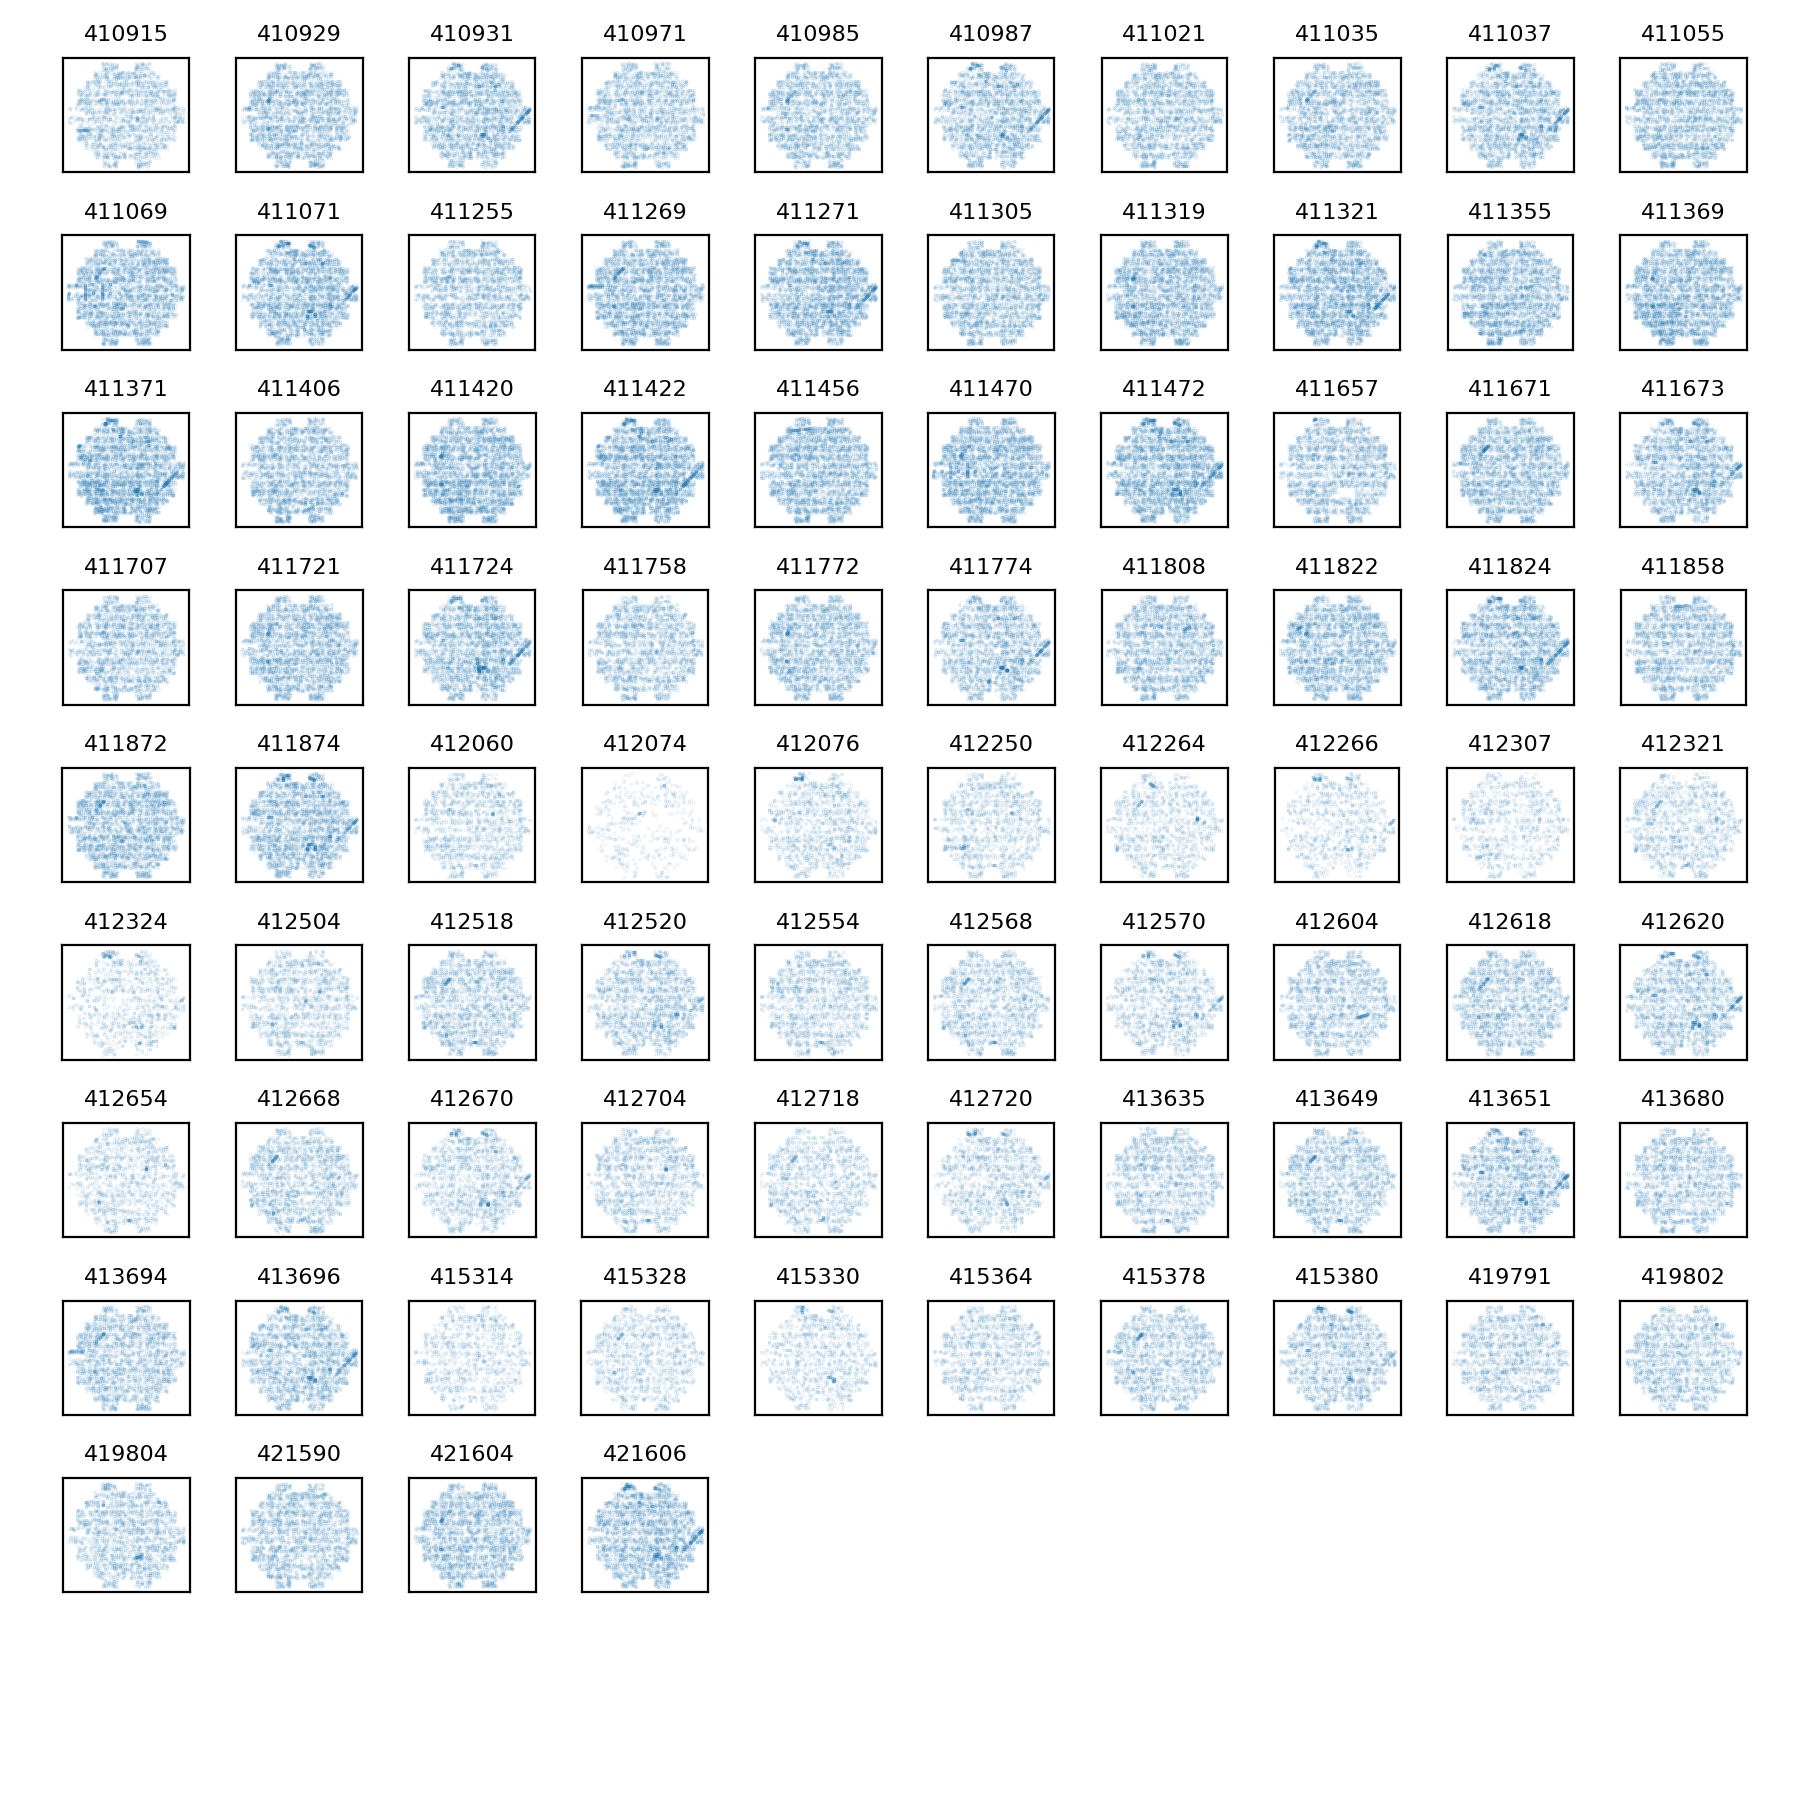

In [10]:
pla.plotDiaSourcesOnSkyGrid(repo, goodSrc)

## Compare to the last two rerun from April and May 2020

In [11]:
repo_old = '/project/mrawls/hits2015/rerun/cw_2020_05'

In [12]:
objTable_old, srcTable_old, goodObj_old, goodSrc_old = pla.loadTables(repo_old)

In [13]:
print(len(srcTable), len(srcTable_old))
print(len(goodSrc), len(goodSrc_old))
print(len(objTable), len(objTable_old))
print(len(goodObj), len(goodObj_old))

671170 669926
229290 228130
247550 246511
59351 58349


In [14]:
repo_older = '/project/mrawls/hits2015/rerun/cw_2020_04'

In [15]:
objTable_older, srcTable_older, goodObj_older, goodSrc_older = pla.loadTables(repo_older)

In [66]:
print(len(srcTable), len(srcTable_older))
print(len(goodSrc), len(goodSrc_older))
print(len(objTable), len(objTable_older))
print(len(goodObj), len(goodObj_older))

671170 618472
229290 210712
247550 176880
59351 48324


<IPython.core.display.Javascript object>


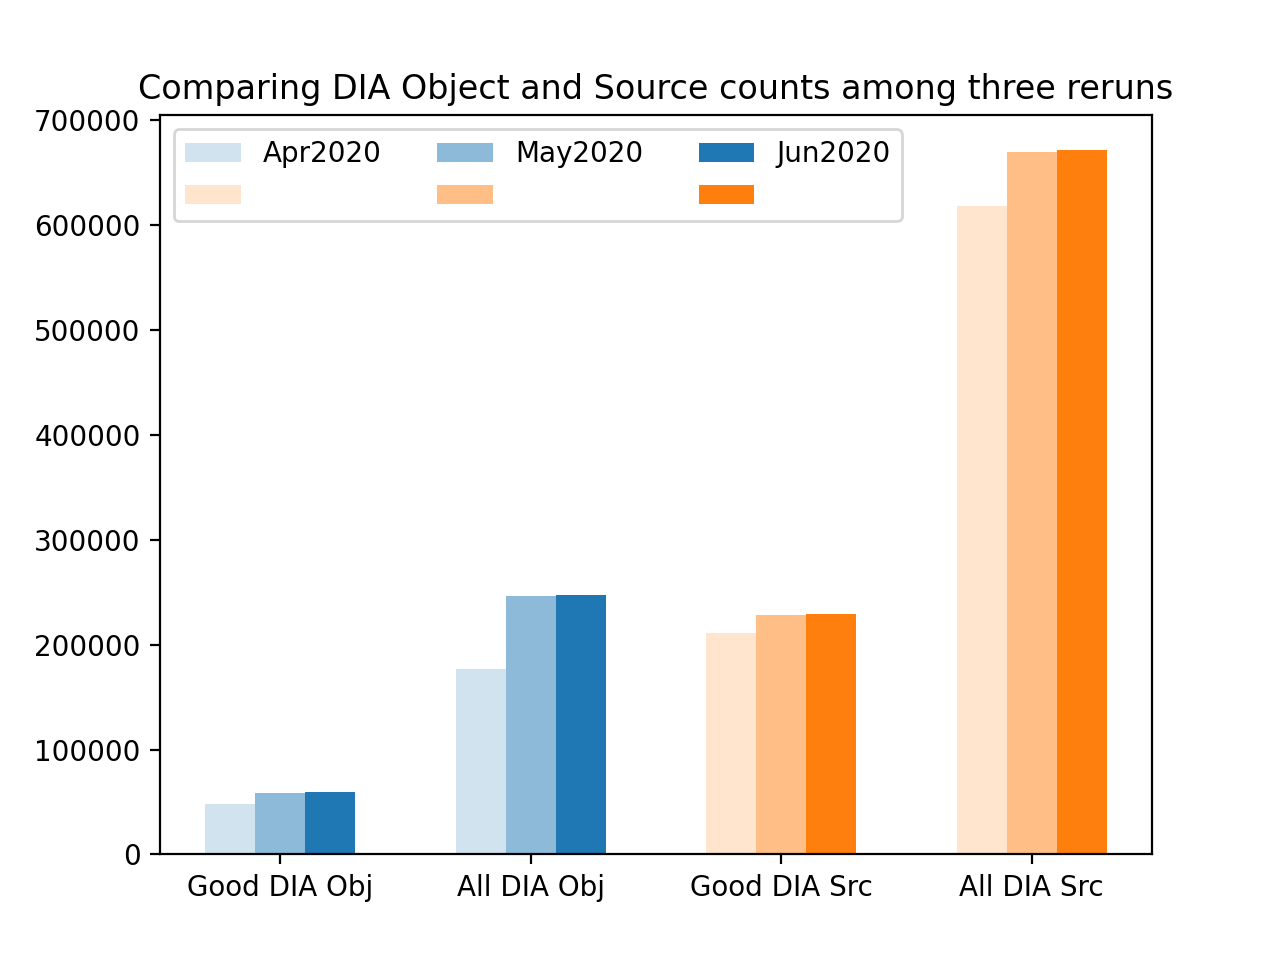

Text(0.5, 1.0, 'Comparing DIA Object and Source counts among three reruns')

In [16]:
srcTable3 = srcTable_older
goodSrc3 = goodSrc_older
objTable3 = objTable_older
goodObj3 = goodObj_older
label3 = "Apr2020"

srcTable1 = srcTable_old
goodSrc1 = goodSrc_old
objTable1 = objTable_old
goodObj1 = goodObj_old
label1 = "May2020"

srcTable2 = srcTable
goodSrc2 = goodSrc
objTable2 = objTable
goodObj2 = goodObj
label2 = "Jun2020"

fig, ax = plt.subplots()
barLabels = ['Good DIA Obj', 'All DIA Obj', 'Good DIA Src', 'All DIA Src']
xbar = np.array([0, 1])
width = 0.2

# April
ax.bar(xbar - width, [len(goodObj3), len(objTable3)], 
       width, label=label3, color='C0', alpha=0.2)
ax.bar(xbar + 2 - width, [len(goodSrc3), len(srcTable3)],
       width, label=' ', color='C1', alpha=0.2)

# May
ax.bar(xbar, [len(goodObj1), len(objTable1)], 
       width, label=label1, color='C0', alpha=0.5)
ax.bar(xbar + 2, [len(goodSrc1), len(srcTable1)],
       width, label=' ', color='C1', alpha=0.5)

# June
ax.bar(xbar + width, [len(goodObj2), len(objTable2)], 
       width, label=label2, color='C0')
ax.bar(xbar + 2 + width, [len(goodSrc2), len(srcTable2)],
       width, label=' ', color='C1')

plt.legend(ncol=3)
ax.set_xticks([0, 1, 2, 3])
labels = ax.set_xticklabels(barLabels)
plt.title('Comparing DIA Object and Source counts among three reruns')

### Overplot April and June DIA Objects to see where the differences are

In [27]:
aprilCoords = SkyCoord(ra=goodObj_older['ra'].values*u.degree, dec=goodObj_older['decl'].values*u.degree)
mayCoords = SkyCoord(ra=goodObj_old['ra'].values*u.degree, dec=goodObj_old['decl'].values*u.degree)
juneCoords = SkyCoord(ra=goodObj['ra'].values*u.degree, dec=goodObj['decl'].values*u.degree)

In [28]:
# I originally tried a crossmatch, but this wasn't actually useful
idxAprJun, d2dAprJun, _ = juneCoords.match_to_catalog_sky(aprilCoords)

<IPython.core.display.Javascript object>


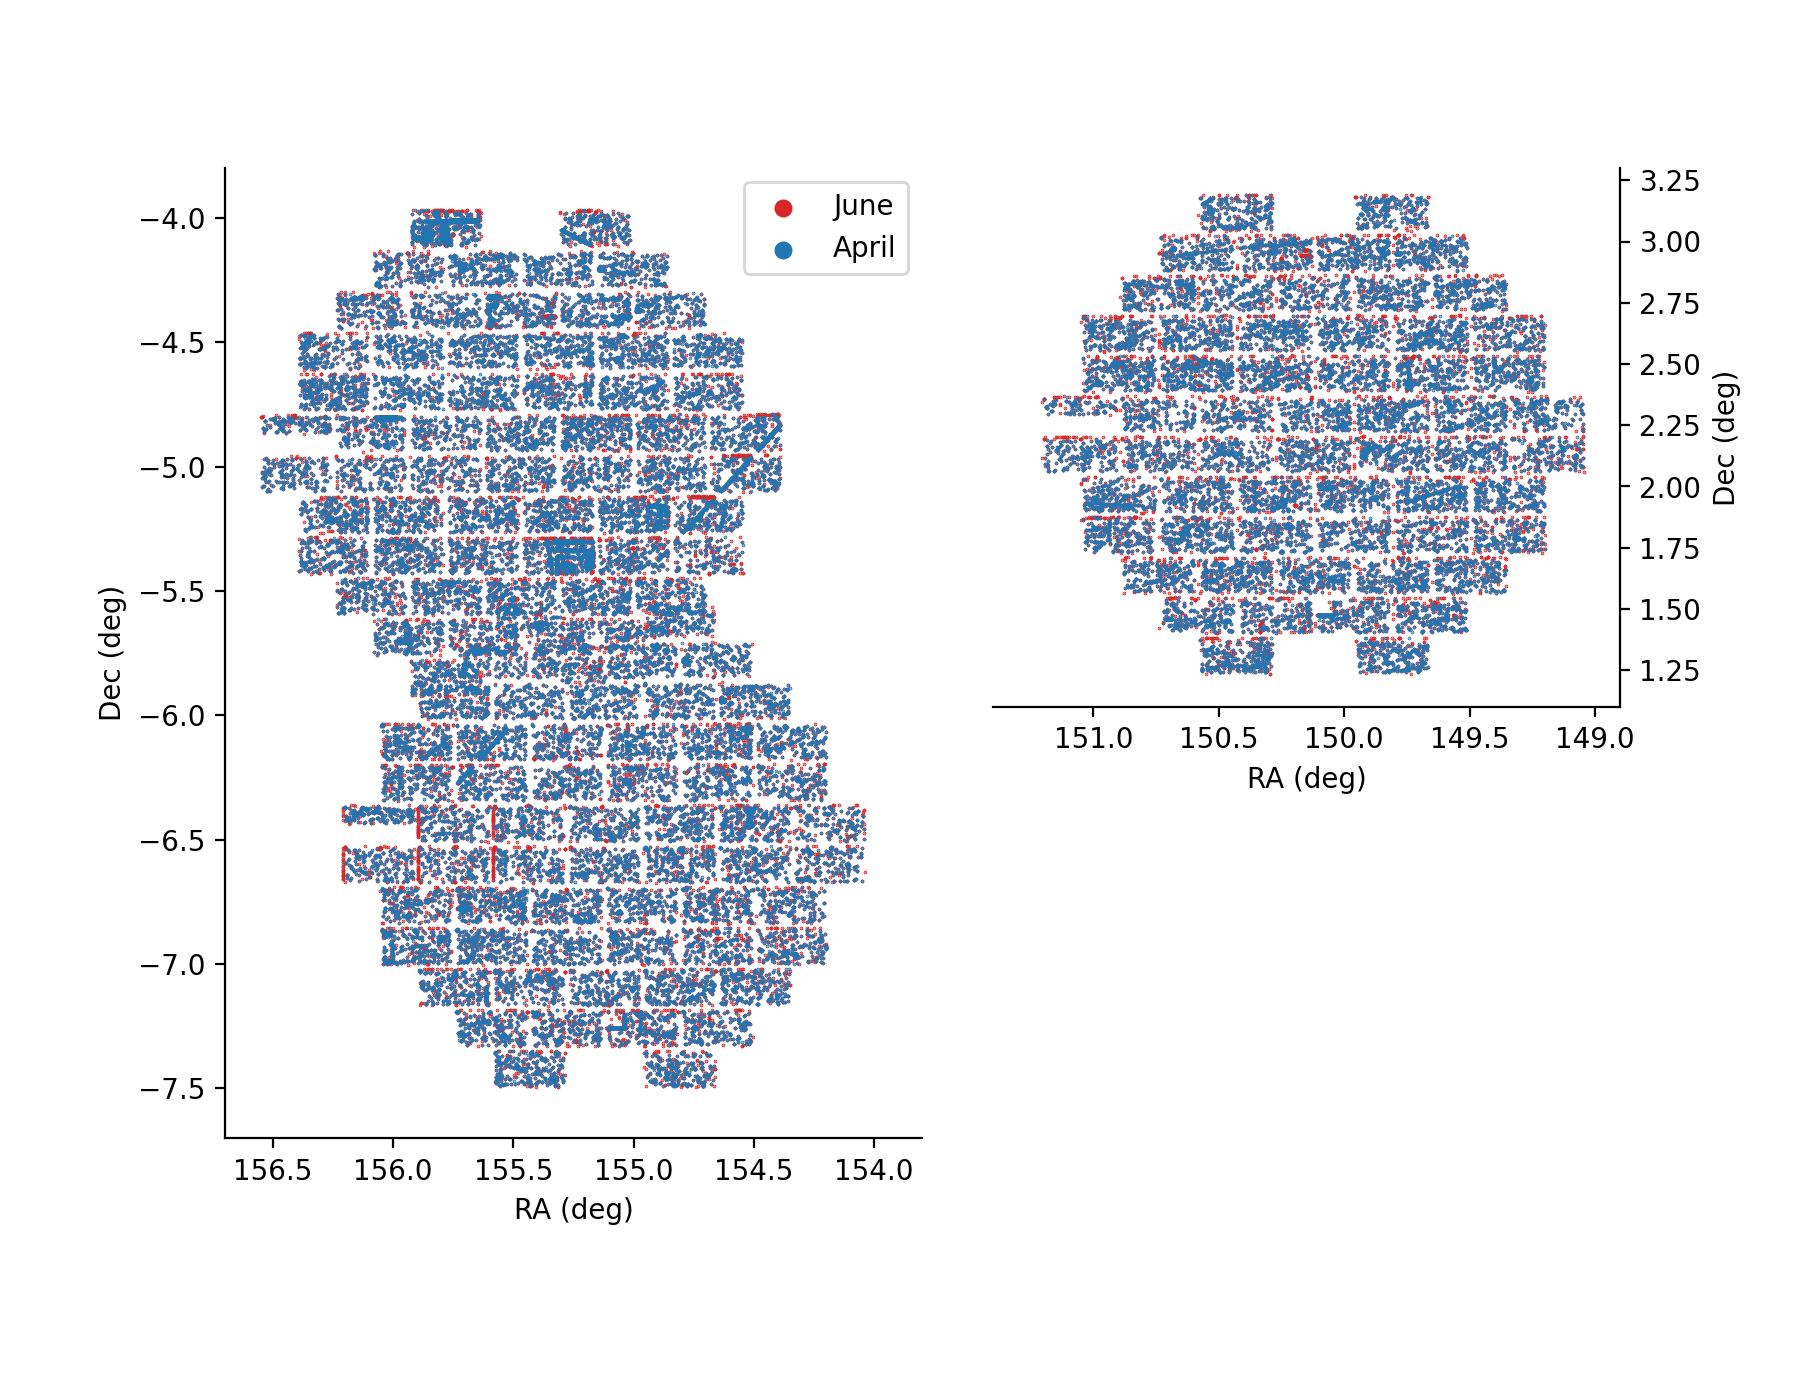

In [67]:
plt.figure(figsize=(9, 7))
ax1 = plt.subplot2grid((100, 100), (0, 55),
                       rowspan=50, colspan=45)  # 1 single HiTS field, on the right
ax2 = plt.subplot2grid((100, 100), (0, 0),
                       rowspan=90, colspan=50)  # 2 overlapping HiTS fields, on the left

#ax1Filter = (juneCoords.dec > -2)
#ax2Filter = (~ax1Filter)

ax1.scatter(juneCoords.ra, juneCoords.dec,
            c='C3', s=0.1, alpha=1, zorder=1, label='June')
ax1.scatter(aprilCoords.ra, aprilCoords.dec,
            c='C0', s=0.1, alpha=1, zorder=2, label='April')

ax2.scatter(juneCoords.ra, juneCoords.dec,
            c='C3', s=0.1, alpha=1, zorder=1, label='June')
ax2.scatter(aprilCoords.ra, aprilCoords.dec,
            c='C0', s=0.1, alpha=1, zorder=2, label='April')

ax1.set_xlabel('RA (deg)')
ax2.set_xlabel('RA (deg)')
ax1.set_ylabel('Dec (deg)')
ax2.set_ylabel('Dec (deg)')

ax1.set_ylim(1.1, 3.3)
ax1.set_xlim(151.4, 148.9)
ax2.set_ylim(-7.7, -3.8)
ax2.set_xlim(156.7, 153.8)

ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
#ax1.invert_xaxis()
#ax2.invert_xaxis()

ax1.yaxis.tick_right()
ax1.yaxis.set_label_position('right')

plt.subplots_adjust(wspace=0.1, hspace=0)

lgnd = ax2.legend()
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]

<IPython.core.display.Javascript object>


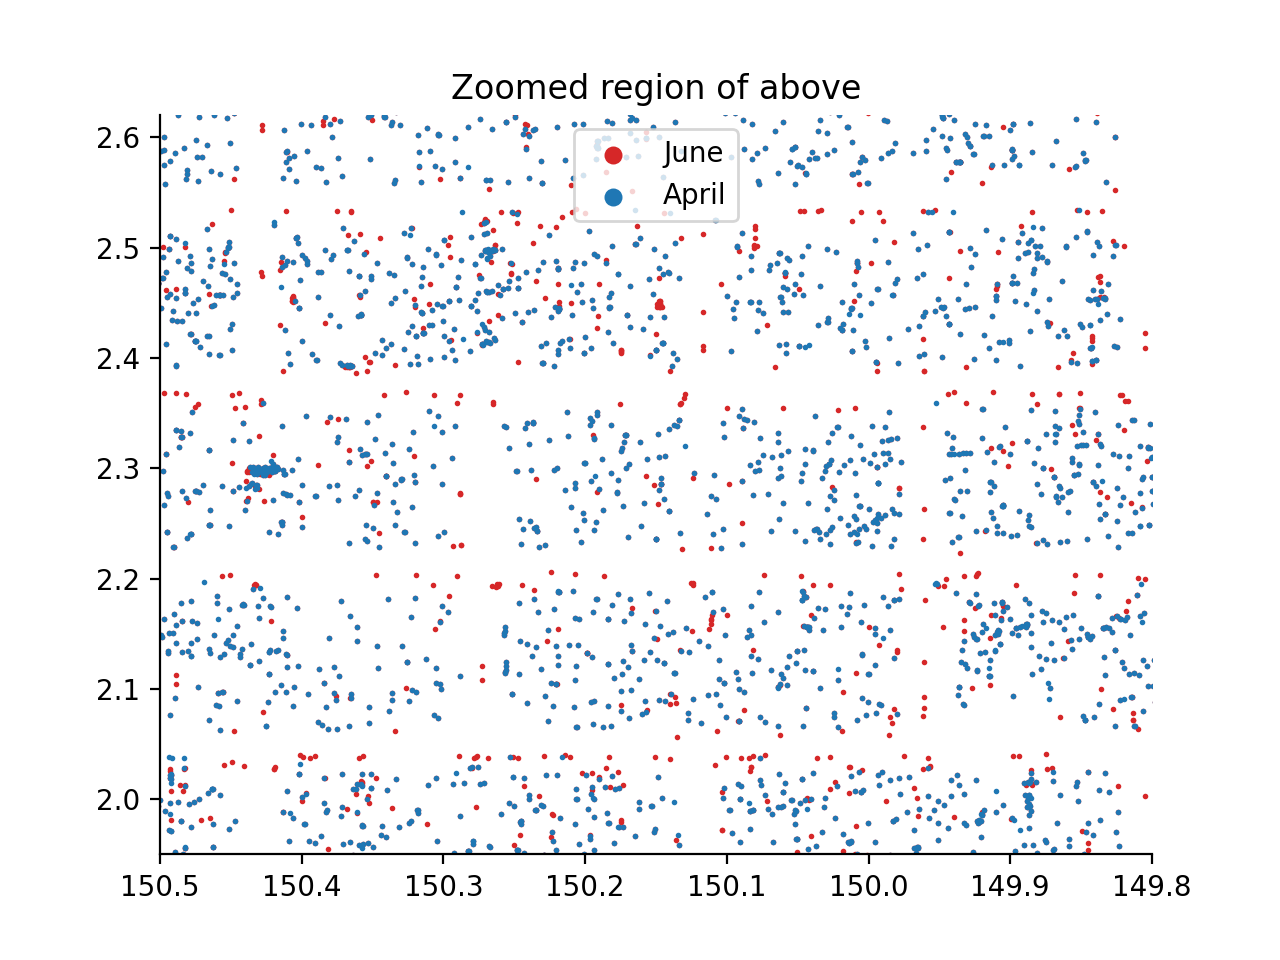

Text(0.5, 1.0, 'Zoomed region of above')

In [74]:
fig, ax = plt.subplots()

plt.scatter(juneCoords.ra, juneCoords.dec,
            c='C3', s=1, alpha=1, zorder=1, label='June')
plt.scatter(aprilCoords.ra, aprilCoords.dec,
            c='C0', s=1, alpha=1, zorder=2, label='April')

ax.set_ylim(1.95, 2.62)
ax.set_xlim(150.5, 149.8)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

lgnd = ax.legend()
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
plt.title("Zoomed region of above")

The new sources are highly concentrated on CCD edges, but they are also all over the place, so we can't fully blame this on edge handling changing.

Let's examine a handful of calexp source catalogs and see if the number of sources changed in there between April and June. If it didn't, this is strictly a difference imaging issue. If it did, the issue is likely somewhere in processCcd.

In [60]:
butler_older = dafPersist.Butler(repo_older)
butler = dafPersist.Butler(repo)

In [68]:
testDataIds = [{'visit': 410985, 'ccd': 47}, {'visit': 410987, 'ccd': 51}, {'visit': 421590, 'ccd': 4}]
for dataId in testDataIds:
    srcApr = butler_older.get('src', dataId)
    srcJun = butler_older.get('src', dataId)
    print('April calexp sources:', len(srcApr))
    print('June calexp sources: ', len(srcJun))

April calexp sources: 2251
June calexp sources:  2251
April calexp sources: 2128
June calexp sources:  2128
April calexp sources: 1620
June calexp sources:  1620


This highly detailed analysis strongly suggests the change is due to something in difference imaging.